In [165]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import visualkeras
from utils.utils import *

In [2]:
train_idxs = read_indexes('./utils/train.txt')
validation_idxs =  read_indexes('./utils/validation.txt')
test_idxs = read_indexes('./utils/test.txt')

In [3]:
data_indexes = [(i+1,j+1) for i in range(5) for j in range(2000)]
parameters = load_parameter_list()
df_parameters = pd.DataFrame(parameters, columns=['cx', 'cy', 'a', 'b', 'theta', 'e1', 'e2'])
df_parameters['data_index'] = data_indexes

y_train = df_parameters[df_parameters['data_index'].isin(train_idxs)].drop('data_index', axis = 1)
y_validation = df_parameters[df_parameters['data_index'].isin(validation_idxs)].drop('data_index', axis = 1)
y_test = df_parameters[df_parameters['data_index'].isin(test_idxs)].drop('data_index', axis = 1)

In [ ]:
X_train = np.array(load_data_multithreaded(train_idxs, small = True))
print('trian loaded')
X_validation = np.array(load_data_multithreaded(validation_idxs, small = True))
print('validation loaded')
X_test = np.array(load_data_multithreaded(test_idxs, small = True))
print('test loaded')

In [149]:
mean = np.mean(X_train.flatten())
std = np.std(X_train.flatten())

In [159]:
mean, std

(0.002895285692411217, 0.01585630079850642)

In [160]:
X_train_norm = (X_train-mean)/std
X_validation_norm = (X_validation-mean)/std
X_test_norm = (X_test-mean)/std

# Feedforward model

In [162]:
# Feedforward model
feedforward = tf.keras.Sequential([
    Flatten(input_shape=(440, 17)),  
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'), 
    Dense(7)                         
])

feedforward.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
feedforward.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_26 (Flatten)        (None, 7480)              0         
                                                                 
 dense_121 (Dense)           (None, 1024)              7660544   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_122 (Dense)           (None, 512)               524800    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_123 (Dense)           (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)             

In [163]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = feedforward.fit(X_train_norm, y_train, validation_data=(X_validation_norm, y_validation), epochs=20, verbose = 1, callbacks=[early_stopping])

Epoch 1/20
133/133 [==============================] - 11s 71ms/step - loss: 1.6469 - mae: 0.9119 - mse: 1.6469 - val_loss: 1.4549 - val_mae: 0.8308 - val_mse: 1.4549
Epoch 2/20
133/133 [==============================] - 10s 72ms/step - loss: 1.5092 - mae: 0.8619 - mse: 1.5092 - val_loss: 1.4635 - val_mae: 0.8315 - val_mse: 1.4635
Epoch 3/20
133/133 [==============================] - 10s 72ms/step - loss: 1.4951 - mae: 0.8530 - mse: 1.4951 - val_loss: 1.4509 - val_mae: 0.8304 - val_mse: 1.4509
Epoch 4/20
133/133 [==============================] - 10s 72ms/step - loss: 1.4789 - mae: 0.8483 - mse: 1.4789 - val_loss: 1.4609 - val_mae: 0.8289 - val_mse: 1.4609
Epoch 5/20
133/133 [==============================] - 10s 72ms/step - loss: 1.4784 - mae: 0.8467 - mse: 1.4784 - val_loss: 1.4553 - val_mae: 0.8289 - val_mse: 1.4553
Epoch 6/20
 16/133 [==>...........................] - ETA: 8s - loss: 1.4452 - mae: 0.8360 - mse: 1.4452

KeyboardInterrupt: 

In [134]:
def plot_metrics(history, metric_name):
    plt.plot(history.history[metric_name])
    plt.plot(history.history[f'val_{metric_name}'])
    plt.title(metric_name.capitalize())
    plt.ylabel(metric_name.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

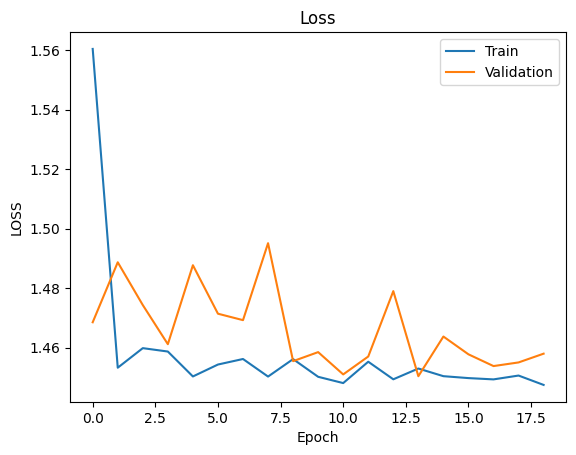

In [135]:
plot_metrics(history, 'loss')

In [136]:
# Model evaluation
def model_evaluation(model, X_test, y_test, random_samples = 5):
    metrics = model.evaluate(X_test, y_test)
    print('Test mae:', metrics[1])
    print('Test mse:', metrics[2])
    random_indices = np.random.choice(len(y_test), size=random_samples, replace=False)
    test_samples = X_test[random_indices]
    predictions = model.predict(test_samples)
    print('\n\nRandom prediction examples')
    print('Parameters:\tcx\tcy\ta\tb\ttheta\te1\te2')
    for i in range(len(predictions)):
        print('------------')
        print('real:\t\t', '\t'.join(f'{val:.3f}' for val in y_test.iloc[random_indices[i]]))
        print('prediction:\t', '\t'.join(f'{val:.3f}' for val in predictions[i]))

model_evaluation(feedforward, X_test, y_test)

45/45 [==============================] - 0s 4ms/step - loss: 1.4266 - mae: 0.8258 - mse: 1.4266
Test mae: 0.8258132934570312
Test mse: 1.4265886545181274
1/1 [==============================] - 0s 92ms/step


Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 0.710	2.457	0.634	0.414	-0.156	5.176	3.062
prediction:	 0.384	3.501	1.289	0.575	0.141	2.678	4.019
------------
real:		 2.126	3.842	1.492	0.303	0.179	0.345	5.631
prediction:	 0.384	3.500	1.289	0.575	0.141	2.678	4.018
------------
real:		 0.176	4.746	0.528	0.397	-0.418	0.928	4.274
prediction:	 0.384	3.501	1.289	0.575	0.141	2.678	4.019
------------
real:		 0.793	5.453	1.438	0.919	0.244	0.077	6.179
prediction:	 0.384	3.501	1.289	0.575	0.141	2.678	4.019
------------
real:		 0.910	2.827	0.617	0.152	0.095	4.626	1.379
prediction:	 0.384	3.501	1.289	0.575	0.141	2.678	4.019


# Convolutional model

In [117]:
cnn = tf.keras.Sequential([
    Conv2D(32, (2, 2), activation='relu', input_shape=(440, 17, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7),
])

cnn.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
cnn.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 439, 16, 32)       160       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 219, 8, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 218, 7, 64)        8256      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 109, 3, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_18 (Flatten)        (None, 20928)             0         
                                                                 
 dense_79 (Dense)            (None, 1024)            

In [118]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=20, verbose = 1, callbacks=[early_stopping])

Epoch 1/20
133/133 [==============================] - 32s 231ms/step - loss: 1.0349 - mae: 0.8111 - mse: 1.0349 - val_loss: 0.9980 - val_mae: 0.7856 - val_mse: 0.9980
Epoch 2/20
133/133 [==============================] - 31s 235ms/step - loss: 1.0299 - mae: 0.8079 - mse: 1.0299 - val_loss: 0.9962 - val_mae: 0.7856 - val_mse: 0.9962
Epoch 3/20
126/133 [===========================>..] - ETA: 1s - loss: 1.0367 - mae: 0.8138 - mse: 1.0367

KeyboardInterrupt: 

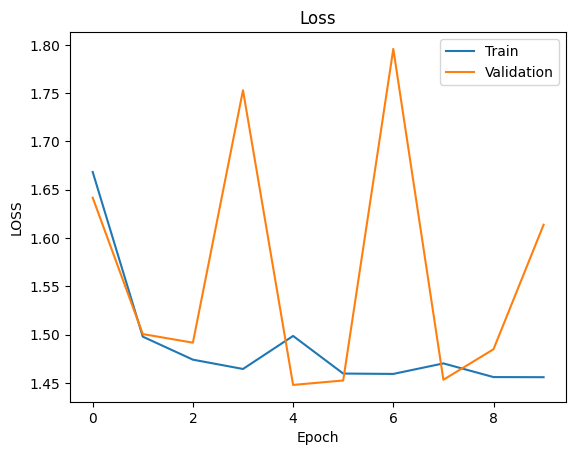

In [105]:
plot_metrics(history, 'loss')

In [106]:
model_evaluation(cnn, X_test, y_test,)

45/45 [==============================] - 1s 21ms/step - loss: 1.4272 - mae: 0.8245 - mse: 1.4272
Test mae: 0.8244684934616089
Test mse: 1.4272178411483765
1/1 [==============================] - 0s 96ms/step


Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 -0.548	4.171	1.151	0.435	0.602	3.779	6.436
prediction:	 0.389	3.627	1.339	0.549	0.172	2.603	4.093
------------
real:		 2.309	3.652	1.674	1.190	0.308	2.491	0.228
prediction:	 0.393	3.624	1.338	0.550	0.174	2.599	4.089
------------
real:		 -0.846	4.443	2.140	0.638	-0.120	6.025	6.570
prediction:	 0.390	3.639	1.339	0.551	0.173	2.607	4.096
------------
real:		 -0.604	2.569	1.023	0.892	0.408	1.093	3.969
prediction:	 0.380	3.621	1.333	0.547	0.166	2.603	4.080
------------
real:		 -0.132	2.752	1.204	1.198	0.393	2.707	6.329
prediction:	 0.379	3.584	1.315	0.543	0.163	2.560	4.019


# Recurrent Neural Network with simple RNN layer

In [109]:
rnn = tf.keras.Sequential([
    SimpleRNN(512, input_shape=(440, 17), return_sequences=True),
    SimpleRNN(128),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='linear')
])

rnn.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
rnn.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 440, 512)          271360    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               82048     
                                                                 
 dense_77 (Dense)            (None, 64)                8256      
                                                                 
 dense_78 (Dense)            (None, 7)                 455       
                                                                 
Total params: 362119 (1.38 MB)
Trainable params: 362119 (1.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [110]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = rnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=20, verbose = 1, callbacks=[early_stopping])

Epoch 1/20
133/133 [==============================] - 50s 361ms/step - loss: 1.6581 - mae: 0.8894 - mse: 1.6581 - val_loss: 1.4519 - val_mae: 0.8288 - val_mse: 1.4519
Epoch 2/20
133/133 [==============================] - 51s 386ms/step - loss: 1.4555 - mae: 0.8387 - mse: 1.4555 - val_loss: 1.4879 - val_mae: 0.8364 - val_mse: 1.4879
Epoch 3/20
133/133 [==============================] - 52s 393ms/step - loss: 1.4561 - mae: 0.8366 - mse: 1.4561 - val_loss: 1.4546 - val_mae: 0.8299 - val_mse: 1.4546
Epoch 4/20
133/133 [==============================] - 52s 392ms/step - loss: 1.4631 - mae: 0.8403 - mse: 1.4631 - val_loss: 1.4827 - val_mae: 0.8389 - val_mse: 1.4827
Epoch 5/20
133/133 [==============================] - 51s 387ms/step - loss: 1.4539 - mae: 0.8386 - mse: 1.4539 - val_loss: 1.4636 - val_mae: 0.8302 - val_mse: 1.4636
Epoch 6/20
133/133 [==============================] - 52s 388ms/step - loss: 1.4518 - mae: 0.8354 - mse: 1.4518 - val_loss: 1.4537 - val_mae: 0.8279 - val_mse: 1.453

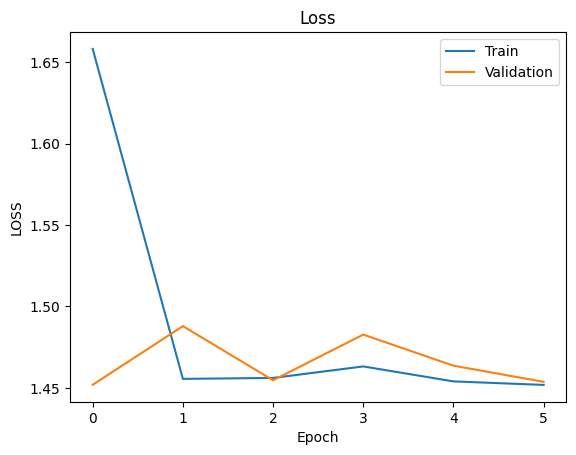

In [111]:
plot_metrics(history, 'loss')

In [112]:
model_evaluation(rnn, X_test, y_test)

45/45 [==============================] - 6s 141ms/step - loss: 1.4291 - mae: 0.8259 - mse: 1.4291
Test mae: 0.8258578777313232
Test mse: 1.429108738899231
1/1 [==============================] - 0s 300ms/step


Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 -0.929	4.911	0.453	0.419	-0.020	3.082	7.142
prediction:	 0.597	3.468	1.389	0.480	0.247	2.635	4.000
------------
real:		 0.433	3.906	1.196	0.451	-0.020	2.013	4.305
prediction:	 0.597	3.468	1.389	0.480	0.247	2.635	4.000
------------
real:		 0.339	4.299	0.823	0.528	0.140	2.335	2.668
prediction:	 0.597	3.468	1.389	0.480	0.247	2.635	4.000
------------
real:		 2.023	2.281	1.880	0.154	0.142	3.662	3.202
prediction:	 0.597	3.468	1.389	0.480	0.247	2.635	4.000
------------
real:		 1.196	2.323	0.578	0.086	0.565	1.076	6.428
prediction:	 0.597	3.468	1.389	0.480	0.247	2.635	4.000


#  Recurrent Neural Network Model with LSTM

In [168]:
rnn_lstm = tf.keras.Sequential([
    LSTM(512, input_shape=(440, 17)),
    Dense(128, activation='relu'),
    Dense(7)
])

rnn_lstm.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
rnn_lstm.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 512)               1085440   
                                                                 
 dense_129 (Dense)           (None, 128)               65664     
                                                                 
 dense_130 (Dense)           (None, 7)                 903       
                                                                 
Total params: 1152007 (4.39 MB)
Trainable params: 1152007 (4.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [169]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = rnn_lstm.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=20, verbose = 1, callbacks=[early_stopping])

Epoch 1/20
133/133 [==============================] - 143s 1s/step - loss: 1.7030 - mae: 0.8982 - mse: 1.7030 - val_loss: 1.4791 - val_mae: 0.8373 - val_mse: 1.4791
Epoch 2/20
133/133 [==============================] - 138s 1s/step - loss: 1.4735 - mae: 0.8432 - mse: 1.4735 - val_loss: 1.4757 - val_mae: 0.8360 - val_mse: 1.4757
Epoch 3/20
133/133 [==============================] - 139s 1s/step - loss: 1.4536 - mae: 0.8356 - mse: 1.4536 - val_loss: 1.4673 - val_mae: 0.8333 - val_mse: 1.4673
Epoch 4/20
133/133 [==============================] - 131s 986ms/step - loss: 1.4592 - mae: 0.8365 - mse: 1.4592 - val_loss: 1.4789 - val_mae: 0.8330 - val_mse: 1.4789
Epoch 5/20
133/133 [==============================] - 130s 982ms/step - loss: 1.4561 - mae: 0.8370 - mse: 1.4561 - val_loss: 1.4662 - val_mae: 0.8347 - val_mse: 1.4662
Epoch 6/20
133/133 [==============================] - 133s 1s/step - loss: 1.4572 - mae: 0.8380 - mse: 1.4572 - val_loss: 1.4663 - val_mae: 0.8399 - val_mse: 1.4663
Epoc

KeyboardInterrupt: 

In [ ]:
plot_metrics(history, 'loss')

In [ ]:
model_evaluation(rnn_lstm, X_test, y_test,)